## Figure 10 Design Space Exploration
### Preparation
Change the `res_path` variable to the path of simulator results. 
Change the `acc_path` variable to the path of algorithm evaluation results

In [3]:
res_path = '../../../simulator/example_sim_results/'
acc_path = '../../../algorithm/example_output/'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

df_m_tile = pd.read_csv(f'{res_path}/dse_a_m_tile_size.csv')
df_vector = pd.read_csv(f'{res_path}/dse_b_vector_size.csv')
df_block = pd.read_csv(f'{res_path}/dse_c_block_size.csv')
df_scatter = pd.read_csv(f'{res_path}/dse_d_num_scatter_accumulator.csv')

df_acc_m_tile = pd.read_csv(f'{acc_path}/dse_a_m_tile_accuracy.csv')
df_acc_vector = pd.read_csv(f'{acc_path}/dse_b_vector_accuracy.csv')
df_acc_block = pd.read_csv(f'{acc_path}/dse_c_block_accuracy.csv')

### (a) GEMM m Tile Size

Plot how adjusting GEMM m tile size in Focus influence latency, buffer size, and model accuracy

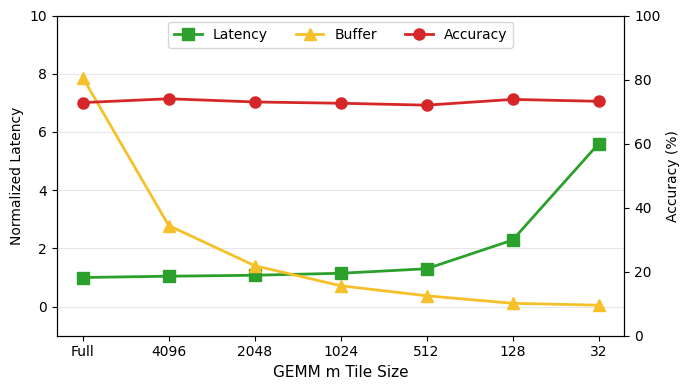

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))
color_lat = '#2ca02c' 
color_buf = '#f6c02a'
color_acc = '#d62728' 

ax_twin = ax.twinx()
baseline_latency_m = df_m_tile['execution_time'].iloc[0]
normalized_latency_m = df_m_tile['execution_time'] / baseline_latency_m
acc = df_acc_m_tile['accuracy'].values

m_tile_labels = []
for val in df_m_tile['m_tile_size']:
    if val == -1:
        m_tile_labels.append('Full')
    else:
        m_tile_labels.append(str(int(val)))

buffer_mb = df_m_tile['total_buffer_capacity'] / (1024*1024)

ax.plot(m_tile_labels, normalized_latency_m, marker='s', 
        markersize=8, color=color_lat, linewidth=2, label='Latency')
ax.plot(m_tile_labels, buffer_mb, marker='^', 
        markersize=8, color=color_buf, linewidth=2, label='Buffer')
ax_twin.plot(m_tile_labels, acc, marker='o', 
             markersize=8, color=color_acc, linewidth=2, label='Accuracy')

ax.set_xlabel('GEMM m Tile Size', fontsize=11)
ax.set_ylabel('Normalized Latency', fontsize=10)
ax_twin.set_ylabel('Accuracy (%)', fontsize=10)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=4)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(-1, 10)
ax_twin.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### (b) Vector Size

Plot the influence of vector size to the number of operation in Focus and to model accuracy

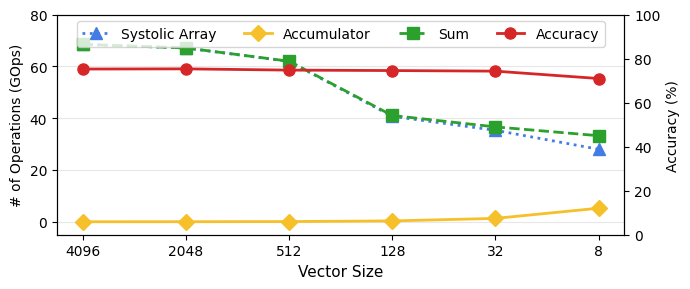

In [6]:
fig, ax = plt.subplots(figsize=(7, 3))
color_sa = '#437ce5'
color_accum = '#f6c02a'
color_sum = '#2ca02c'
color_acc = '#d62728' 

ax_twin = ax.twinx()
x_labels = ['4096', '2048', '512', '128', '32', '8']
acc = df_acc_vector['accuracy'].values
df_vector_filtered = df_vector.iloc[:10]
gops = df_vector_filtered['layer_array_ops'] / (1024**3)
accumulator_ops = df_vector_filtered['layer_scatter_ops'] / (1024**3)

ax.plot(x_labels, gops, marker='^', markersize=8, 
        color=color_sa, linestyle='dotted', linewidth=2, label='Systolic Array')
ax.plot(x_labels, accumulator_ops, marker='D', 
        markersize=8, color=color_accum, linewidth=2, label='Accumulator')
ax.plot(x_labels, accumulator_ops+gops, marker='s', 
        markersize=8, linestyle='--', color=color_sum, linewidth=2, label='Sum')
ax_twin.plot(x_labels, acc, marker='o', 
             markersize=8, color=color_acc, linewidth=2, label='Accuracy')

ax.set_xlabel('Vector Size', fontsize=11)
ax.set_ylabel('# of Operations (GOps)', fontsize=10)
ax_twin.set_ylabel('Accuracy (%)', fontsize=10)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=4)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(-5, 80)
ax_twin.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### (c) SIC Block Size

Plot how block size in Similarity Concentrator influence latency and accuracy

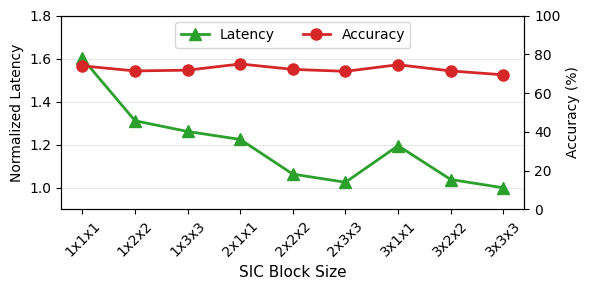

In [30]:
fig, ax = plt.subplots(figsize=(6, 3))
color_lat = '#2ca02c' 
color_acc = '#d62728' 

ax_twin = ax.twinx()
desired_order = ['1x1x1', '1x2x2', '1x3x3', '2x1x1', '2x2x2', '2x3x3', '3x1x1', '3x2x2', '3x3x3']

acc_dict = dict(zip(df_acc_block['block_size'], df_acc_block['accuracy']))
acc = [acc_dict[label] for label in desired_order]

data_dict = {}
for idx, row in df_block.iterrows():
    block_size = row['block_size']
    if block_size not in data_dict:
        data_dict[block_size] = {
            'execution_time': row['execution_time'],
            'total_energy': row['total_energy']
        }

ordered_latency = []
ordered_labels = []
for label in desired_order:
    if label in data_dict:
        ordered_latency.append(data_dict[label]['execution_time'])
        ordered_labels.append(label)

baseline_latency_block = ordered_latency[-1]
normalized_latency_block = [lat / baseline_latency_block for lat in ordered_latency]

ax.plot(range(len(ordered_labels)), normalized_latency_block, 
        marker='^', markersize=8, color=color_lat, linewidth=2, label='Latency')
ax_twin.plot(range(len(ordered_labels)), acc, 
        marker='o', markersize=8, color=color_acc, linewidth=2, label='Accuracy')

ax.set_xlabel('SIC Block Size', fontsize=11)
ax.set_ylabel('Normalized Latency', fontsize=10)
ax_twin.set_ylabel('Accuracy (%)', fontsize=10)
ax.set_xticks(range(len(ordered_labels)))
ax.set_xticklabels(ordered_labels, rotation=45)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=2)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02))
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0.9, 1.8)
ax_twin.set_ylim(0, 100)
plt.tight_layout()
plt.show()

### (d) Scatter Accumulator

Plot how adjusting number of scatter accumulator influence execution latency and buffer area (influence number of SRAM ports).

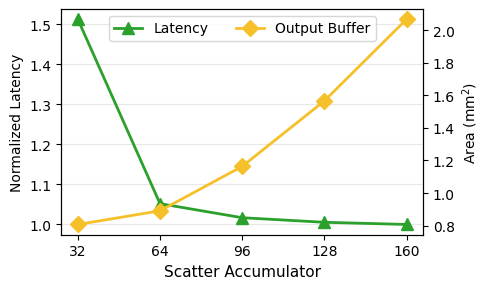

In [31]:
fig, ax = plt.subplots(figsize=(5, 3))
color_lat = '#2ca02c' 
color_buf = '#f6c02a'

ax_twin = ax.twinx()
num_scatter = df_scatter['num_scatter']
buffer_area = df_scatter['buffer_area']
baseline_latency_scatter = df_scatter['execution_time'].iloc[-1]
normalized_latency_scatter = df_scatter['execution_time'][:5] / baseline_latency_scatter

x_labels = [32, 64, 96, 128, 160]
ax.plot(x_labels, normalized_latency_scatter, 
        marker='^', markersize=8,
        color=color_lat, linewidth=2, label='Latency')
ax_twin.plot(x_labels, buffer_area, 
             marker='D', markersize=8,
             color=color_buf, linewidth=2, label='Output Buffer')

ax.set_xlabel('Scatter Accumulator', fontsize=11)
ax.set_ylabel('Normalized Latency', fontsize=10)
ax_twin.set_ylabel(r'Area (mm$^2$)', fontsize=10)
ax.set_xticks(x_labels)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()